In [44]:
from dust3r.inference import inference, load_model
from dust3r.utils.image import load_images
from dust3r.image_pairs import make_pairs
from dust3r.cloud_opt import global_aligner, GlobalAlignerMode  

import os 

In [45]:
model_path = "checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_linear.pth"
device = 'cuda'
batch_size = 1
schedule = 'linear'
lr = 0.01
niter = 300

image_dir = '..\\images'
image_files = []

# Use os.listdir to get all files in the directory
for file in os.listdir(image_dir):
    image_files.append(os.path.join(image_dir, file)) 

print(image_files)

['../images\\000011.jpg', '../images\\000009.jpg', '../images\\000003.jpg', '../images\\000001.jpg']


In [46]:
image_files.sort(key=str.lower)  
image_files 


['../images\\000001.jpg',
 '../images\\000003.jpg',
 '../images\\000009.jpg',
 '../images\\000011.jpg']

In [47]:
model = load_model(model_path, device)
# load_images can take a list of images or a directory
images = load_images(image_files, size=512)
pairs = make_pairs(images, scene_graph='complete', prefilter=None, symmetrize=True)
output = inference(pairs, model, device, batch_size=batch_size) 

... loading model from checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_linear.pth


KeyboardInterrupt: 

In [ ]:
print(output.keys())

dict_keys(['view1', 'view2', 'pred1', 'pred2', 'loss'])


In [ ]:
print(output['view1'].keys())

dict_keys(['img', 'true_shape', 'idx', 'instance'])


In [ ]:
import matplotlib.pyplot as plt 

print(*(output['view1']['img'])[0].shape[1:])

512 288


In [ ]:
scene = global_aligner(output, device=device, mode=GlobalAlignerMode.PointCloudOptimizer)
loss = scene.compute_global_alignment(init="mst", niter=niter, schedule=schedule, lr=lr)

 init edge (3*,2*) score=31.320486068725586
 init edge (3,4*) score=30.300182342529297
 init edge (2,1*) score=23.230817794799805
 init edge (3,0*) score=11.601628303527832
 init loss = 0.04377753660082817
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals', 'im_conf.0', 'im_conf.1', 'im_conf.2', 'im_conf.3', 'im_conf.4']


100%|██████████| 300/300 [13:46<00:00,  2.76s/it, lr=0.01 loss=0.015043] 


In [ ]:
# retrieve useful values from scene:
imgs = scene.imgs
focals = scene.get_focals()
poses = scene.get_im_poses()
pts3d = scene.get_pts3d()
confidence_masks = scene.get_masks() 
K = scene.get_intrinsics()
depths = scene.get_depthmaps()
conf_vals = scene.get_conf() 


In [ ]:
import torch

save_dir = '..\\dust3r_outputs'

torch.save(imgs, f'{save_dir}/imgs.pt')  
torch.save(focals, f'{save_dir}/focals.pt')  
torch.save(poses, f'{save_dir}/poses.pt')   
torch.save(pts3d, f'{save_dir}/pts3d.pt') 
torch.save(confidence_masks, f'{save_dir}/confidence_masks.pt') 
torch.save(K, f'{save_dir}/intrinsics.pt')
torch.save(depths, f'{save_dir}/depths.pt')
torch.save(conf_vals, f'{save_dir}/conf_vals.pt')

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np

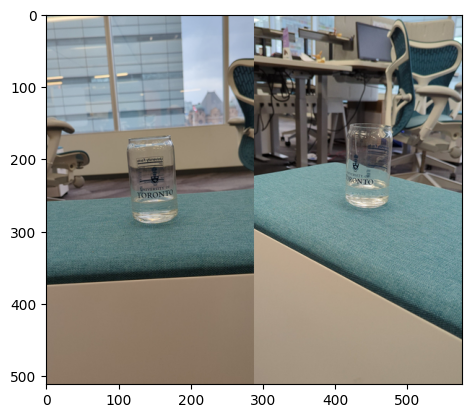

In [ ]:
H0, W0, H1, W1 = *imgs[0].shape[:2], *imgs[1].shape[:2]
img0 = np.pad(imgs[0], ((0, max(H1 - H0, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
img1 = np.pad(imgs[1], ((0, max(H0 - H1, 0)), (0, 0), (0, 0)), 'constant', constant_values=0) 

img = np.concatenate((img0, img1), axis=1) 
plt.imshow(img) 

In [ ]:
print(poses.shape)

torch.Size([5, 4, 4])


In [ ]:
print(poses[0])

tensor([[-0.8173, -0.0873,  0.5696, -0.3566],
        [ 0.2747,  0.8098,  0.5183, -0.4339],
        [-0.5065,  0.5801, -0.6379,  1.1492],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [ ]:
print(pts3d[0].shape)

torch.Size([512, 288, 3])


In [ ]:
print(focals)

tensor([[479.4620],
        [447.7977],
        [438.2399],
        [437.8585],
        [452.4086]], device='cuda:0', grad_fn=<ExpBackward0>)


In [ ]:
poses

tensor([[[-0.8173, -0.0873,  0.5696, -0.3566],
         [ 0.2747,  0.8098,  0.5183, -0.4339],
         [-0.5065,  0.5801, -0.6379,  1.1492],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[-0.2703, -0.3243,  0.9065, -0.5991],
         [ 0.3086,  0.8627,  0.4006, -0.3092],
         [-0.9120,  0.3881, -0.1331,  0.7894],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.2314, -0.3518,  0.9070, -0.5400],
         [ 0.3281,  0.9059,  0.2676, -0.1735],
         [-0.9159,  0.2357,  0.3250,  0.4700],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.9998,  0.0179,  0.0113,  0.0000],
         [-0.0178,  0.9997, -0.0158,  0.0000],
         [-0.0116,  0.0156,  0.9998,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.7652,  0.2193, -0.6053,  0.4641],
         [-0.2365,  0.9702,  0.0526, -0.0766],
         [ 0.5989,  0.1029,  0.7942,  0.1303],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0',
       grad_fn=<CopySlices>)

In [ ]:
import open3d as o3d

def save_ply(pcd_array:torch.Tensor, filename): 
    pcd = o3d.geometry.PointCloud()  
    pcd.points = o3d.utility.Vector3dVector(pcd_array) 
 
    o3d.io.write_point_cloud(filename, pcd) 
    

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
H,W = pts3d[0].shape[:2] 

print(pts3d[0].view(H*W, 3).shape) 

torch.Size([147456, 3])


In [ ]:
pcd_array = pts3d[0].view(H*W, 3).detach().cpu().numpy() 
save_ply(pcd_array, 'input.ply') 

In [ ]:
conf_vals[0]

tensor([[2.9670e-03, 3.3476e-03, 3.6500e-03,  ..., 7.9850e-04, 7.9600e-04,
         8.0529e-04],
        [2.8939e-03, 3.6005e-03, 4.1454e-03,  ..., 7.4561e-04, 7.5550e-04,
         7.5383e-04],
        [2.3617e-03, 3.0533e-03, 3.7634e-03,  ..., 7.4419e-04, 7.6729e-04,
         7.3978e-04],
        ...,
        [1.1774e+00, 1.2135e+00, 1.2388e+00,  ..., 1.3796e+00, 1.3742e+00,
         1.3650e+00],
        [1.1231e+00, 1.1710e+00, 1.1986e+00,  ..., 1.3749e+00, 1.3703e+00,
         1.3589e+00],
        [1.0814e+00, 1.1117e+00, 1.1402e+00,  ..., 1.3714e+00, 1.3683e+00,
         1.3546e+00]], device='cuda:0', grad_fn=<LogBackward0>)

In [ ]:
from demo_run import get_3D_model_from_scene 

silent = False 
min_conf_thr = 3 
as_pointcloud = True 
mask_sky = False 
clean_depth = True 
transparent_cams = True 
cam_size = 0.05 

outfile = get_3D_model_from_scene('./', silent, scene, min_conf_thr, as_pointcloud, mask_sky,
                                    clean_depth, transparent_cams, cam_size) 

PCT:  <trimesh.PointCloud(vertices.shape=(354239, 3))>
(exporting 3D scene to ./scene.glb )


In [ ]:
scene.get_im_poses()

tensor([[[-0.8173, -0.0873,  0.5696, -0.3566],
         [ 0.2747,  0.8098,  0.5183, -0.4339],
         [-0.5065,  0.5801, -0.6379,  1.1492],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[-0.2703, -0.3243,  0.9065, -0.5991],
         [ 0.3086,  0.8627,  0.4006, -0.3092],
         [-0.9120,  0.3881, -0.1331,  0.7894],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.2314, -0.3518,  0.9070, -0.5400],
         [ 0.3281,  0.9059,  0.2676, -0.1735],
         [-0.9159,  0.2357,  0.3250,  0.4700],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.9998,  0.0179,  0.0113,  0.0000],
         [-0.0178,  0.9997, -0.0158,  0.0000],
         [-0.0116,  0.0156,  0.9998,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.7652,  0.2193, -0.6053,  0.4641],
         [-0.2365,  0.9702,  0.0526, -0.0766],
         [ 0.5989,  0.1029,  0.7942,  0.1303],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0',
       grad_fn=<CopySlices>)

In [ ]:
import numpy as np 

pts = torch.concatenate([p[m] for p, m in zip(pts3d, confidence_masks)])  
pts 

tensor([[ 0.0416, -0.0912,  0.6692],
        [ 0.0402, -0.0909,  0.6687],
        [ 0.0388, -0.0907,  0.6682],
        ...,
        [ 0.3160,  0.1734,  0.5865],
        [ 0.2014,  0.2104,  0.4984],
        [ 0.2021,  0.2103,  0.4992]], device='cuda:0', grad_fn=<CatBackward0>)

In [ ]:
pts.shape

torch.Size([402931, 3])

In [ ]:
confidence_masks[0].shape

torch.Size([512, 288])